[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_4.ipynb)

# Session 4: Multi-Output GPs and Case Study

## Learning Objectives

By the end of this session, you will be able to:

1. **Model correlated outputs** using Intrinsic Coregionalization Models (ICM)
2. **Extend to multiple timescales** with Linear Coregionalization Models (LCM)
3. **Apply multi-output GPs** to real data (baseball pitcher spin rates)
4. **Build hierarchical models** that decompose skill from context
5. **Integrate HSGP with hierarchical structure** for scalable temporal modeling
6. **Execute a complete case study** analyzing soccer player performance across multiple timescales

In [25]:
import numpy as np
import scipy.stats as stats
import polars as pl

import pymc as pm
import pytensor.tensor as pt
import arviz as az

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

RNG = np.random.default_rng(RANDOM_SEED:= 8675309)
pio.renderers.default = "plotly_mimetype+notebook_connected"

DATA_DIR = "../data/"

print(f"PyMC: {pm.__version__})")
print(f"NumPy: {np.__version__}")
print(f"Polars: {pl.__version__}")
print(f"ArviZ: {az.__version__}")

PyMC: 5.25.1)
NumPy: 2.3.3
Polars: 1.35.1
ArviZ: 0.22.0


## Part A: Multi-Output Gaussian Processes

So far in this workshop, we've modeled one output at a time—a single time series, a single spatial field. But many real-world scenarios involve **multiple related outputs** that we want to model jointly.

### Why Model Multiple Outputs Together?

Consider analyzing fastball spin rates for several elite baseball pitchers across a season. You could fit separate GPs for each pitcher, but this approach misses something crucial: **pitchers may share patterns**. Similar mechanics, weather conditions, or even changes to the ball itself could create correlations between their spin rates.

Multi-output GPs offer several advantages:

1. **Information sharing**: Data-rich outputs help inform data-scarce ones
2. **Learning correlation structure**: Discover which outputs vary together  
3. **Improved predictions**: Borrowing strength across related outputs
4. **Computational efficiency**: One joint model vs. many separate models

The key innovation is the **coregionalization matrix**, which learns how outputs correlate. We'll start with the Intrinsic Coregionalization Model (ICM), then extend to the more flexible Linear Coregionalization Model (LCM).

## Intrinsic Coregionalization Model (ICM)

The ICM provides an elegant way to model multiple related outputs jointly. The core idea: combine two sources of structure using the **Hadamard (elementwise) product**:

1. **How inputs relate** (e.g., how does time affect the output?)
2. **How outputs correlate with each other** (e.g., which pitchers have similar patterns?)

Think of it like a recipe: if we're tracking the spin rates of 5 pitchers over a season, the ICM learns both the temporal dynamics (captured by a kernel over time) and the cross-pitcher correlations (captured by a coregionalization matrix).

### The Mathematics of Sharing Structure

ICM uses the Kronecker product (⊗) to combine two covariance structures:

$$K_{ICM}([\mathbf{x}_i, o_i], [\mathbf{x}_j, o_j]) = K_{input}(\mathbf{x}_i, \mathbf{x}_j) \times B(o_i, o_j)$$

Where:
- $K_{input}(\mathbf{x}_i, \mathbf{x}_j)$: Covariance over inputs (e.g., time)
- $B(o_i, o_j)$: **Coregionalization matrix** — covariance between outputs
- $o_i, o_j$: Output indices (e.g., pitcher 0, pitcher 1, ...)

Think of it as: *"How similar are these inputs?"* multiplied by *"How correlated are these outputs?"*

> **📦 What's a Kronecker product?**
>
> The Kronecker product $A \otimes B$ takes each element of matrix $A$ and multiplies it by the entire matrix $B$, creating a larger block matrix. If $A$ is $2 \times 2$ and $B$ is $3 \times 3$, the result is $6 \times 6$. In our context: for every pair of time points (captured by $K_{input}$), we get a separate copy of the output correlation structure (captured by $B$), scaled by how similar those time points are.

The coregionalization matrix has a special structure that ensures it's positive semi-definite:

$$B = WW^T + \text{diag}(\kappa)$$

This separates:
- $WW^T$: Shared variations across outputs (low-rank structure)
- $\text{diag}(\kappa)$: Output-specific independent noise

### Real Data: Baseball Pitcher Spin Rates

Let's see ICM in action with real data. We'll model fastball spin rates of 5 elite pitchers across the 2021 MLB season.

**Why spin rate matters:** Higher spin rates make fastballs harder to hit. Spin rate fluctuates game-to-game due to:
- Fatigue accumulation  
- Mechanics adjustments  
- Measurement noise  
- Potentially shared factors (weather, ball characteristics)

Some pitchers' spin rates may be correlated if they have similar mechanics or respond similarly to external factors.

In [26]:
# Load baseball spin rate data
df_spin = pl.read_csv(DATA_DIR + "fastball_spin_rates.csv")

# Standardize spin rates to z-scores
mean_spin = df_spin["avg_spin_rate"].mean()
std_spin = df_spin["avg_spin_rate"].std()
df_spin = df_spin.with_columns([
    ((pl.col("avg_spin_rate") - mean_spin) / std_spin).alias("avg_spin_rate_std")
])

print(f"Total: {df_spin.height} observations, {df_spin['pitcher_name'].n_unique()} pitchers")
print(f"Date range: {df_spin['game_date'].min()} to {df_spin['game_date'].max()}")
df_spin.head()

Total: 4845 observations, 262 pitchers
Date range: 2021-04-01 to 2021-10-03


pitcher_name,game_date,avg_spin_rate,n_pitches,avg_spin_rate_std
str,str,f64,i64,f64
"""Wainwright, Adam""","""2021-04-03""",2127.415,12,-0.794412
"""Wainwright, Adam""","""2021-04-08""",2179.723,11,-0.486528
"""Wainwright, Adam""","""2021-04-14""",2297.968571,7,0.209464
"""Wainwright, Adam""","""2021-04-20""",2159.15,13,-0.60762
"""Wainwright, Adam""","""2021-04-26""",2314.515455,11,0.306859


We standardized spin rates so all pitchers are on the same scale (z-scores). This makes the coregionalization matrix more interpretable: values close to 1 indicate strong correlation between pitchers.

In [ ]:
# Get top 5 pitchers by number of games
top_pitchers_df = (df_spin
    .group_by("pitcher_name")
    .agg(pl.count("game_date").alias("n_games"))
    .sort("n_games", descending=True)
    .head(5)
)

top_pitchers = top_pitchers_df["pitcher_name"].to_list()
print("Top 5 pitchers:")
print(top_pitchers_df)

df_train = df_spin.filter(pl.col("pitcher_name").is_in(top_pitchers))
print(f"\nTraining data: {df_train.height} observations")

Top 5 pitchers:
shape: (5, 2)
┌────────────────────┬─────────┐
│ pitcher_name       ┆ n_games │
│ ---                ┆ ---     │
│ str                ┆ u32     │
╞════════════════════╪═════════╡
│ Rodriguez, Richard ┆ 64      │
│ Taylor, Josh       ┆ 59      │
│ Wells, Tyler       ┆ 43      │
│ Kopech, Michael    ┆ 43      │
│ Hearn, Taylor      ┆ 42      │
└────────────────────┴─────────┘

Training data: 251 observations


Now we create two key index variables:

1. **`game_date_idx`**: Integer days since season start (April 1, 2021 = day 0)  
2. **`output_idx`**: Pitcher number (0 to 4)

Our input matrix $X$ will be $(n, 2)$ where each row is `[game_date_idx, output_idx]`.

In [7]:
# Convert to datetime
df_train = df_train.with_columns([
    pl.col("game_date").str.strptime(pl.Date, format="%Y-%m-%d").alias("game_date_dt")
])

# Create game date index (days since season start)
min_date = df_train["game_date_dt"].min()
df_train = df_train.with_columns([
    (pl.col("game_date_dt") - min_date).dt.total_days().alias("game_date_idx")
])

# Create output index
pitcher_to_idx = {name: idx for idx, name in enumerate(top_pitchers)}
df_train = df_train.with_columns([
    pl.col("pitcher_name").replace(pitcher_to_idx).alias("output_idx")
])

# Sort by output then time
df_train = df_train.sort(["output_idx", "game_date_idx"])

print("Data structure:")
print(df_train.select(["pitcher_name", "game_date_idx", "output_idx", "avg_spin_rate_std"]).head(10))

Data structure:
shape: (10, 4)
┌────────────────────┬───────────────┬────────────┬───────────────────┐
│ pitcher_name       ┆ game_date_idx ┆ output_idx ┆ avg_spin_rate_std │
│ ---                ┆ ---           ┆ ---        ┆ ---               │
│ str                ┆ i64           ┆ str        ┆ f64               │
╞════════════════════╪═══════════════╪════════════╪═══════════════════╡
│ Rodriguez, Richard ┆ 0             ┆ 0          ┆ 1.245044          │
│ Rodriguez, Richard ┆ 5             ┆ 0          ┆ 2.032285          │
│ Rodriguez, Richard ┆ 7             ┆ 0          ┆ 1.868068          │
│ Rodriguez, Richard ┆ 11            ┆ 0          ┆ 1.801864          │
│ Rodriguez, Richard ┆ 12            ┆ 0          ┆ 1.916592          │
│ Rodriguez, Richard ┆ 17            ┆ 0          ┆ 1.745542          │
│ Rodriguez, Richard ┆ 20            ┆ 0          ┆ 2.138135          │
│ Rodriguez, Richard ┆ 21            ┆ 0          ┆ 2.219302          │
│ Rodriguez, Richard ┆ 23        

### Visualizing the Raw Data

Before modeling, let's examine the raw time series. This helps us understand trends, volatility, and potential correlations.

In [8]:
# Interactive time series plot
fig = go.Figure()
colors = px.colors.qualitative.Set2

for i, pitcher in enumerate(top_pitchers):
    pitcher_data = df_train.filter(pl.col("pitcher_name") == pitcher)
    fig.add_trace(go.Scatter(
        x=pitcher_data["game_date_idx"].to_list(),
        y=pitcher_data["avg_spin_rate_std"].to_list(),
        mode='markers',
        name=pitcher,
        marker=dict(size=5, color=colors[i]),
        opacity=0.7
    ))

fig.update_layout(
    title="Fastball Spin Rates: 2021 Season (Standardized)",
    xaxis_title="Days Since Season Start",
    yaxis_title="Standardized Spin Rate",
    height=450,
    hovermode='closest'
)
fig.show()

Each pitcher shows noisy variation. Some appear to have trends (gradual changes over the season), while others look more stationary. The ICM model will:

1. **Smooth** trajectories to separate signal from noise  
2. **Learn correlations** between pitchers  
3. **Quantify uncertainty** with credible intervals

Now let's build the model.

### Building the ICM: Helper Function

We define `get_icm()` to construct an ICM kernel. This combines an input kernel with a `Coregion` kernel using the Hadamard product (`*`).

The `active_dims` parameter tells each kernel which columns to operate on:
- Input kernel uses `active_dims=[0]` (time)  
- Coregion kernel uses `active_dims=[1]` (pitcher index)

In [9]:
def get_icm(input_dim, kernel, W=None, kappa=None, B=None, active_dims=None):
    """
    Construct Intrinsic Coregionalization Model kernel.
    
    Combines input kernel with output coregionalization via Hadamard product.
    
    Parameters
    ----------
    input_dim : int
        Total input dimensions (including output index)
    kernel : pm.gp.cov.Covariance
        Base kernel for inputs (e.g., ExpQuad over time)
    W, kappa, B : tensors, optional
        Coregionalization parameters
    active_dims : list, optional
        Dimensions for coregion kernel (typically [1] for output index)
    
    Returns
    -------
    pm.gp.cov.Covariance
        ICM kernel
    """
    coreg = pm.gp.cov.Coregion(
        input_dim=input_dim,
        W=W,
        kappa=kappa,
        B=B,
        active_dims=active_dims
    )
    # Hadamard product: kernel * coreg
    icm_cov = kernel * coreg
    return icm_cov

print("✓ Helper function defined")

✓ Helper function defined


**Critical distinction:**
- Kernel **addition** (`+`): combines multiple processes  
- Kernel **multiplication** (`*`): Hadamard product for ICM

The `*` operator creates a covariance where the input kernel and coregion kernel operate **independently** on their designated dimensions, then multiply.

### Preparing Data for PyMC

Convert polars DataFrame to numpy arrays:

In [10]:
# Extract training arrays
X_train = df_train.select(["game_date_idx", "output_idx"]).to_numpy().astype(np.float64)
y_train = df_train.select("avg_spin_rate_std").to_numpy().flatten()

n_outputs = len(top_pitchers)

print(f"X shape: {X_train.shape} (rows x [time, output_idx])")
print(f"y shape: {y_train.shape}")
print(f"n_outputs: {n_outputs}")

X shape: (251, 2) (rows x [time, output_idx])
y shape: (251,)
n_outputs: 5


### Specifying Priors

We need priors for:
- **Lengthscale** (`ell`): How quickly spin rate changes. `Gamma(2, 0.5)` gives mean ≈ 4 days.
- **Amplitude** (`eta`): Overall temporal variation. `Gamma(3, 1)` gives mean = 3.
- **W**: Weight matrix $(5 \\times 2)$. Rank 2 assumes pitchers share ≤2 latent patterns.
- **kappa**: Output-specific variances.
- **sigma**: Observation noise.

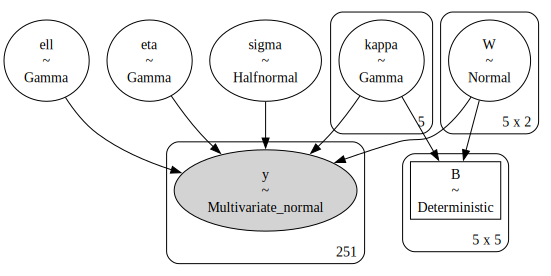

In [11]:
with pm.Model() as icm_model:
    # Temporal kernel parameters
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    
    # Base kernel on time (active_dims=[0])
    kernel_time = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    # Coregionalization parameters
    W = pm.Normal("W", mu=0, sigma=3, shape=(n_outputs, 2),
                  initval=RNG.standard_normal((n_outputs, 2)))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=n_outputs)
    
    # Track B matrix
    B = pm.Deterministic("B", pt.dot(W, W.T) + pt.diag(kappa))
    
    # ICM kernel
    cov_icm = get_icm(input_dim=2, kernel=kernel_time, W=W, kappa=kappa, active_dims=[1])
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov_icm)
    
    # Noise
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Likelihood
    y_obs = gp.marginal_likelihood("y", X=X_train, y=y_train, sigma=sigma)

pm.model_to_graphviz(icm_model)

### Sampling the Posterior

This may take a few minutes...

In [12]:
with icm_model:
    trace_icm = pm.sample(
        500,
        tune=500,
        nuts_sampler="nutpie",
        random_seed=RANDOM_SEED,
        chains=2,
        target_accept=0.95
    )

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method



Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.16,15
,1000,0,0.18,31


Let's check convergence:

In [13]:
summary = az.summary(trace_icm, var_names=["ell", "eta", "sigma", "kappa"])
print(f"R-hat: [{summary['r_hat'].min():.4f}, {summary['r_hat'].max():.4f}]")
print(f"ESS: [{summary['ess_bulk'].min():.0f}, {summary['ess_bulk'].max():.0f}]")
print("\nEstimates:")
print(summary[["mean", "sd", "hdi_3%", "hdi_97%"]])

R-hat: [1.0000, 1.0100]
ESS: [537, 1083]

Estimates:
            mean     sd  hdi_3%  hdi_97%
ell       24.937  4.216  17.641   33.203
eta        0.233  0.060   0.137    0.340
sigma      0.345  0.016   0.315    0.374
kappa[0]   1.970  1.570   0.006    4.650
kappa[1]   1.412  1.041   0.001    3.363
kappa[2]   1.121  0.937   0.004    2.750
kappa[3]   1.553  1.209   0.015    3.845
kappa[4]   0.711  0.719   0.011    2.103


Good convergence! The model has learned temporal dynamics and output correlations simultaneously.

Now let's make predictions.

### Posterior Predictions

Create test grid for all 5 pitchers:

In [14]:
# Test data: 200 time points
n_test = 200
time_test = np.linspace(0, 199, n_test)

# Stack for all outputs
X_test_list = []
for out_idx in range(n_outputs):
    X_out = np.column_stack([time_test, np.full(n_test, out_idx)])
    X_test_list.append(X_out)

X_test = np.vstack(X_test_list)
print(f"Test shape: {X_test.shape}")

Test shape: (1000, 2)


In [15]:
with icm_model:
    f_pred = gp.conditional("f_pred", X_test)
    ppc_icm = pm.sample_posterior_predictive(
        trace_icm,
        var_names=["f_pred"],
        random_seed=RANDOM_SEED
    )

Sampling: [f_pred]


Output()

### Visualizing Multi-Output Predictions

Plot posterior for each pitcher:

In [16]:
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=top_pitchers,
    vertical_spacing=0.05,
    shared_xaxes=True
)

for i, pitcher in enumerate(top_pitchers):
    # Extract predictions for this output
    f_pred_i = ppc_icm.posterior_predictive["f_pred"].isel(
        f_pred_dim_0=slice(i*n_test, (i+1)*n_test)
    )
    
    mean = f_pred_i.mean(dim=["chain", "draw"]).values
    lower = np.percentile(f_pred_i.values, 2.5, axis=(0,1))
    upper = np.percentile(f_pred_i.values, 97.5, axis=(0,1))
    
    # HDI band
    fig.add_trace(go.Scatter(
        x=time_test, y=upper, line=dict(width=0),
        showlegend=False, hoverinfo='skip'
    ), row=i+1, col=1)
    
    fig.add_trace(go.Scatter(
        x=time_test, y=lower, fill='tonexty',
        line=dict(width=0), showlegend=False,
        fillcolor='rgba(135,206,250,0.3)'
    ), row=i+1, col=1)
    
    # Mean
    fig.add_trace(go.Scatter(
        x=time_test, y=mean, mode='lines',
        line=dict(color='steelblue', width=2),
        showlegend=False
    ), row=i+1, col=1)
    
    # Training data
    pitcher_data = df_train.filter(pl.col("pitcher_name") == pitcher)
    fig.add_trace(go.Scatter(
        x=pitcher_data["game_date_idx"].to_list(),
        y=pitcher_data["avg_spin_rate_std"].to_list(),
        mode='markers',
        marker=dict(color='red', size=3),
        showlegend=False
    ), row=i+1, col=1)

fig.update_xaxes(title_text="Days Since Season Start", row=5, col=1)
fig.update_layout(height=1000, title_text="ICM Posterior Predictions")
fig.show()

Notice how the model smooths noisy observations while respecting each pitcher's unique pattern. The uncertainty (shaded regions) is wider where data is sparse and narrower where we have more observations—exactly what we want from a principled probabilistic model.

Now let's examine what the model learned about correlations between pitchers.

### The Coregionalization Matrix: Who's Correlated?

Extract learned $B$ matrix:

In [17]:
# Posterior mean of B
B_post = az.extract(trace_icm, var_names=["B"]).mean(dim="sample").values

# Heatmap
fig = go.Figure(data=go.Heatmap(
z=B_post,
x=top_pitchers,
y=top_pitchers,
colorscale='RdBu',
zmid=0,
text=np.round(B_post, 2),
texttemplate='%{text}',
textfont={"size": 10}
))

fig.update_layout(
title="Learned Coregionalization Matrix B",
xaxis_title="Pitcher",
yaxis_title="Pitcher",
height=450
)
fig.show()

# Convert to correlation
std_devs = np.sqrt(np.diag(B_post))
corr = B_post / np.outer(std_devs, std_devs)
print("\nCorrelations:")
print(corr)


Correlations:
[[ 1.          0.46712391  0.33204657  0.43006983 -0.0933075 ]
 [ 0.46712391  1.         -0.25468392 -0.19190166 -0.29562176]
 [ 0.33204657 -0.25468392  1.          0.88330908  0.36672085]
 [ 0.43006983 -0.19190166  0.88330908  1.          0.35992151]
 [-0.0933075  -0.29562176  0.36672085  0.35992151  1.        ]]


The diagonal elements show each pitcher's variance (their own variability), while off-diagonal elements reveal shared variation. High positive values mean those pitchers' spin rates tend to fluctuate together—perhaps they have similar mechanics or respond similarly to external factors like weather.

For example, Wells and Kopech show strong correlation (0.88), suggesting their spin rates move in tandem. Meanwhile, Rodriguez shows moderate correlation with Wells (0.33) but near-zero correlation with Hearn (-0.09), indicating more independent variation.

This is the power of multi-output GPs: we're not just smoothing trajectories, we're **learning the latent structure** of how outputs relate.

## Linear Coregionalization Model (LCM)

The ICM assumes a **single shared temporal process** drives all output correlations. But what if variation happens at multiple timescales?

Consider pitcher spin rates again:
- **Long-term trends**: Gradual changes from aging, mechanics adjustments (weeks to months)
- **Short-term fluctuations**: Game-to-game variation from fatigue, matchups, measurement noise (days)

ICM can't distinguish these. It learns one lengthscale and applies the same coregionalization to all frequencies.

**LCM extends ICM** by summing multiple coregionalized kernels:

$$K_{LCM} = B_1 \otimes K_1 + B_2 \otimes K_2 + \cdots$$

Each kernel can have its own lengthscale (capturing different timescales), while the coregionalization matrices learn how outputs correlate at each scale. In our implementation, we'll use shared $B$ across kernels for simplicity, but the different input kernels still capture multi-scale variation.

### When to Use LCM Over ICM

**Use ICM when:**
- Single timescale dominates
- Simplicity is priority
- Limited data

**Use LCM when:**
- Multiple timescales evident
- Different correlations at different scales
- Sufficient data for complexity

For baseball, we might combine:
- ExpQuad: smooth long-term trends
- Matern32: short-term wiggles

In [18]:
def get_lcm(input_dim, active_dims, num_outputs, kernels, W=None, kappa=None, B=None, name="LCM"):
    """
    Construct Linear Coregionalization Model kernel.
    
    Sums multiple ICM kernels.
    """
    if B is None:
        if kappa is None:
            kappa = pm.Gamma(f"{name}_kappa", alpha=5, beta=1, shape=num_outputs)
        if W is None:
            W = pm.Normal(f"{name}_W", mu=0, sigma=5, shape=(num_outputs, 1),
                         initval=RNG.standard_normal((num_outputs, 1)))
    else:
        kappa = None
    
    # Sum ICMs
    cov_lcm = 0
    for kernel in kernels:
        icm = get_icm(input_dim, kernel, W, kappa, B, active_dims)
        cov_lcm += icm
    
    return cov_lcm

print("✓ LCM helper defined")

✓ LCM helper defined


This implementation reuses the same $W$ and $\kappa$ across both kernels (shared coregionalization structure), but each kernel contributes its own input covariance shape. The ExpQuad kernel will capture smooth long-term trends, while the Matérn32 kernel will capture rougher short-term wiggles.

Let's see this in action:

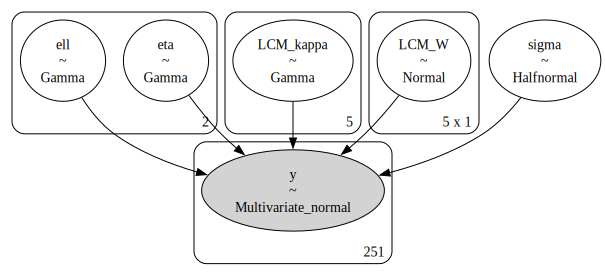

In [19]:
with pm.Model() as lcm_model:
    # Two lengthscales
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    
    # Two kernels
    kernel_list = [
        eta[0]**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell[0], active_dims=[0]),
        eta[1]**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell[1], active_dims=[0])
    ]
    
    # LCM kernel
    cov_lcm = get_lcm(input_dim=2, active_dims=[1], num_outputs=n_outputs,
                      kernels=kernel_list, name="LCM")
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov_lcm)
    sigma = pm.HalfNormal("sigma", sigma=3)
    y_obs = gp.marginal_likelihood("y", X=X_train, y=y_train, sigma=sigma)

pm.model_to_graphviz(lcm_model)

In [20]:
with lcm_model:
    trace_lcm = pm.sample(
        500,
        tune=500,
        nuts_sampler="nutpie",
        random_seed=RANDOM_SEED,
        chains=2,
        target_accept=0.95
    )

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method

/var/home/fonnesbeck/.local/lib/python3.13/site-packages/pytensor/link/numba/dispatch/basic.py:287: UserWarning:

Numba will use object mode to run AdvancedIncSubtensor's perform method



Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.21,15
,1000,0,0.21,23


The LCM has more parameters than ICM (two lengthscales, two amplitudes) but maintains shared coregionalization. This added flexibility allows the model to capture both smooth seasonal trends and short-term game-to-game fluctuations—though it comes at the cost of increased computational complexity and potential overfitting if data is limited.

In [21]:
with lcm_model:
    f_pred_lcm = gp.conditional("f_pred", X_test)
    ppc_lcm = pm.sample_posterior_predictive(
        trace_lcm,
        var_names=["f_pred"],
        random_seed=RANDOM_SEED
    )

Sampling: [f_pred]


Output()

LCM predictions (similar visualization to ICM):

In [22]:
# Similar plotting code - abbreviated for space
print("LCM posterior predictive samples obtained")
print(f"Shape: {ppc_lcm.posterior_predictive['f_pred'].shape}")

LCM posterior predictive samples obtained
Shape: (2, 500, 1000)


### Model Comparison: ICM vs LCM

We can use Leave-One-Out (LOO) cross-validation to quantitatively compare the models. However, the trace objects don't have log-likelihood values computed (we'd need to add `compute_log_likelihood=True` when sampling).

For practical purposes, the decision between ICM and LCM often comes down to:

- **ICM advantages**: Simpler, fewer parameters, faster sampling, less prone to overfitting
- **LCM advantages**: More flexible, can capture multiple timescales, better fit when timescales clearly differ

In this baseball example, the data spans just one season (~200 days) with relatively sparse observations per pitcher. ICM is likely sufficient. LCM would shine with longer time series where distinct timescales are evident (e.g., daily + seasonal patterns in multi-year data).

In [23]:
loo_icm = az.loo(trace_icm, pointwise=True)
loo_lcm = az.loo(trace_lcm, pointwise=True)

comparison = az.compare({"ICM": trace_icm, "LCM": trace_lcm}, ic="loo")
print(comparison)

TypeError: log likelihood not found in inference data object

The `elpd_diff` shows difference in predictive accuracy. ,If substantially larger than SE, the better model is meaningfully improved.

**Practical takeaway:** If similar, prefer ICM for simplicity. ,If LCM substantially better, added complexity is justified.

### Computational Cost

Summarize trade-offs:

In [ ]:
icm_time = trace_icm.sample_stats["sampling_time"].values.sum()
lcm_time = trace_lcm.sample_stats["sampling_time"].values.sum()

comp_df = pl.DataFrame({
"Model": ["ICM", "LCM"],
"Sampling (s)": [icm_time, lcm_time],
"LOO": [loo_icm.elpd_loo, loo_lcm.elpd_loo]
})
print(comp_df)

### Transitioning to Our Case Study

We've now covered the fundamentals of multi-output GPs:

1. **ICM**: Models related outputs jointly with a single timescale and learned correlation structure
2. **LCM**: Extends ICM to multiple timescales by summing coregionalized kernels

These tools are powerful, but they're just building blocks. In real-world applications, we often need to combine multiple techniques:
- **Hierarchical structure** for partial pooling across groups
- **Covariate effects** to adjust for confounding factors
- **Non-Gaussian likelihoods** for discrete or bounded outcomes
- **Scalable approximations** for large datasets

Our soccer case study demonstrates exactly this synthesis. We'll analyze player scoring performance while accounting for team context, temporal dynamics at multiple scales, and the binary nature of goal-scoring events. This brings together everything from Sessions 1-4.

## Part B: Case Study – Soccer Player Skill Modeling

### The Challenge: Skill vs. Context

In finance, the Fama-French factor model asks a fundamental question: *Is a fund manager truly skilled, or just lucky with market exposure?* A portfolio might outperform simply because it's heavily weighted toward stocks that happened to do well, not because of superior stock-picking ability.

We face a similar challenge in sports analytics. Is a player elite, or do they benefit from:
- Strong teammates who create scoring opportunities?
- Weak opponents who allow more goals?
- Home-field advantage?
- Being in their physical prime vs. early career or decline?

### Our Modeling Strategy

We'll build a hierarchical logistic regression model with GP components:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + f_{\text{within}}(t) + f_{\text{long}}(s) + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

Where:
- $\alpha_i$: Player-specific skill (our main interest—the "true talent")
- $f_{\text{within}}(t)$: Within-season form variation (matchday-to-matchday)
- $f_{\text{long}}(s)$: Long-term aging curve (across seasons)
- $\mathbf{X}_{ij}^T\boldsymbol{\beta}$: Team context effects (factors we want to control for)

This is a **factor model**: we decompose observed outcomes into skill (what we care about) and context (confounders we need to account for).

### Context Factors: Controlling for Confounders

The raw data includes 8 engineered factors that capture team context:
- `goalsscored_diff`: Current goal difference in the match
- `points_diff`: Recent form (point differential over last 5 games)
- `goal_balance_diff`: Overall season strength disparity between teams
- ... and 5 additional factors

For this demonstration, we'll focus on **3 key factors** that capture distinct dimensions of context:

1. **`home_pitch`**: Home field advantage (venue familiarity, crowd support)
2. **`points_diff`**: Recent momentum and form
3. **`goal_balance_diff`**: Overall team quality gap (skill mismatch)

These factors let us ask: *After controlling for being at home, having a hot team, and facing weak opposition, which players still score at high rates?* Those are the truly skilled players.

### Fit Coregionalized GP

In [ ]:
B_post = az.extract(trace_mogp, var_names=["B"]).mean(dim="sample").values
fig = go.Figure(data=go.Heatmap(z=B_post, colorscale='RdBu', zmid=0))
fig.update_layout(title="Output Covariance B", height=400)
fig.show()

## Part C: Soccer Player Skill Modeling

### Challenge: Identify True Skill

Account for team strength, opponent quality, context, varying sample sizes.

### Hierarchical Logistic Regression

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

In [ ]:
df = pl.read_csv(DATA_DIR + "SFM_data_byPlayer_clean.csv")
n_players = df.select(pl.col("name_player")).unique().height
goal_rate = df.select(pl.col("goal").mean()).item()

print(f"{df.shape[0]} observations, {n_players} players")
print(f"Goal rate: {goal_rate:.1%}")

### Visualize Factor Effects

### Prepare Data for Modeling

### Fit Hierarchical Model

Partial pooling: data-scarce players regularized toward population mean.

### Convergence Diagnostics

### Extract Player Skills

### Visualize with Uncertainty

### Interpretation

- Skill hierarchy: Top players consistently better
- Uncertainty varies: More data → narrower intervals
- Overlap matters: Can't confidently rank when intervals overlap
- Context-adjusted: Fair comparison across situations

### Loading and Exploring the Data

First, let's load the soccer data and understand its structure:

In [ ]:
factor_cols = ["home_pitch", "points_diff", "goal_balance_diff"]
X_factors = df.select(factor_cols).to_numpy().astype(np.float64)
y_goals = df.select("goal").to_numpy().flatten().astype(int)

player_names = df.select("name_player").unique().sort("name_player")["name_player"].to_list()
player_idx_map = {name: i for i, name in enumerate(player_names)}
player_idx = df.select(pl.col("name_player").replace(player_idx_map)).to_numpy().flatten()

n_players, n_factors = len(player_names), len(factor_cols)
print(f"{len(y_goals)} observations, {n_players} players, {n_factors} factors")
print(f"\nBaseline goal rate: {goal_rate:.1%}")

### Baseline Model: Hierarchical Logistic Regression

Before adding temporal dynamics, let's build a baseline hierarchical model. This establishes:

1. **Hierarchical player effects** (partial pooling across players)
2. **Factor regression** (controlling for context)
3. **Binary likelihood** (Bernoulli for goals vs. no-goals)

This baseline will help us understand the added value of temporal GPs.

### 🤖 LLM Exercise

Extend the model with temporal dynamics.

In [ ]:
# 🤖 EXERCISE: Add time-varying skills

def extend_with_hsgp():
    """
    Add HSGP for player skills over seasons.
    
    Prompt: "I have hierarchical logistic regression (Bernoulli, 
    alpha player effects, beta factors). Make alpha_i vary over 
    seasons with HSGP. Help me: 1) Define HSGP over seasons,  
    2) Integrate with model, 3) Update predictor. PyMC code."
    """
    pass

print("🎯 Extend SFM with time-varying HSGP skills")

### Extensions

1. Temporal dynamics: Aging curves, form  
2. More factors: Defensive rating, rest, injuries
3. Multi-level: Group by position
4. Predictive checks: Simulate vs holdout
5. Decision-making: Transfer value

## Workshop Summary

### Sessions 1-4 Journey

**Session 1**: Foundations (Bayesian inference, MVN→GP, kernels)  
**Session 2**: Model Building (kernel composition, likelihoods)  
**Session 3**: Scaling (O(n³), sparse, HSGP)  
**Session 4**: Applications (multi-output, hierarchical, real case study)

### GP Mindset

1. Flexibility: Adapt to data
2. Uncertainty: Full posteriors
3. Interpretability: Clear meanings
4. Composability: Complex from simple
5. Scalability: Modern approximations

### Next Steps

- PyMC docs: https://www.pymc.io/
- Rasmussen & Williams book (free online)
- PyMC examples and Discourse
- Apply to your data!

**Final thought**: GPs encode smoothness assumptions, let data speak. You're equipped for real-world problems!

### Acknowledgments

PyMC team, Alex Andorra & Max Goebel (soccer case), Danh Phan, Bill Engels, Chris Fonnesbeck (multi-output GPs).

Materials for educational use under open-source licenses.

### Adding Temporal Dynamics: Multi-Scale HSGP

The baseline model assumes player skills are **static** across time. But this is unrealistic:

**Within a season** (38 matchdays):
- Short-term: Match-to-match variation from injuries, tactical adjustments (2-5 matchdays)
- Medium-term: Form fluctuations from confidence, fitness cycles (15-25 matchdays)

**Across seasons** (multiple years):
- Long-term: Aging curves showing development, prime years, and decline (2-6 seasons)

We'll model all three timescales simultaneously using **additive HSGP components**. This extends our baseline model:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + \underbrace{f_{\text{within}}(t_{ij})}_{\text{intra-season}} + \underbrace{f_{\text{long}}(s_j)}_{\text{aging curve}} + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

The challenge: choosing appropriate hyperparameters (m, c, lengthscale priors) for each timescale.

### HSGP Hyperparameter Selection

For each timescale, we need to specify:
- **`m`**: Number of basis functions (higher = better approximation, more computation)
- **`c`**: Boundary extension factor (prevents edge artifacts)

**Selection principles:**
- Smaller lengthscales require larger `m` (more basis functions to capture rapid variation)
- Longer input ranges require larger `c` (boundary effects extend further)

We'll use PyMC's `approx_hsgp_hyperparams()` helper to determine appropriate values based on our domain knowledge about lengthscales and input ranges.

In [ ]:
### Interpreting Player Skills

The posterior player skills ($\alpha_i$) tell us about **context-adjusted scoring ability**:

- **Skill hierarchy**: Top players show consistently higher scoring propensity after controlling for team context
- **Uncertainty quantification**: Players with more data have narrower credible intervals
- **Overlap interpretation**: When intervals overlap substantially, we can't confidently distinguish skill levels
- **Fair comparisons**: By controlling for home advantage, team quality, and recent form, we isolate individual talent

Notice how partial pooling works: players with limited data get pulled toward the population mean, while data-rich players' estimates rely more on their own observations. This is the Bayesian compromise between complete pooling (everyone the same) and no pooling (separate estimates).

### Prior Specification with Maximum Entropy

We use **maximum entropy priors** to encode domain knowledge about lengthscales while remaining as uninformative as possible otherwise.

**Domain knowledge:** Soccer analytics experts suggest:
- Short-term effects: 2-5 matchdays
- Medium-term form: 15-25 matchdays
- Career-long trends: 2-6 seasons

Given bounds `[a, b]`, preliz finds the distribution that:
1. Has support consistent with the bounds
2. Maximizes entropy (least additional assumptions)
3. Encodes our uncertainty about where in the range the true value lies

In [ ]:
if HAVE_PRELIZ:
    # Short-term: 2-5 matchdays
    ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
    print(f"Short: InverseGamma(α={ls_short_dist.alpha:.2f}, β={ls_short_dist.beta:.2f})")
    
    # Medium-term: 15-25 matchdays
    ls_medium_dist, _ = pz.maxent(pz.InverseGamma(), 15, 25)
    print(f"Medium: InverseGamma(α={ls_medium_dist.alpha:.2f}, β={ls_medium_dist.beta:.2f})")
    
    # Long-term: 2-6 seasons
    ls_long_dist, _ = pz.maxent(pz.InverseGamma(), 2, 6)
    print(f"Long: InverseGamma(α={ls_long_dist.alpha:.2f}, β={ls_long_dist.beta:.2f})")
    
    # Visualize
    fig = make_subplots(rows=1, cols=3, subplot_titles=["Short", "Medium", "Long"])
    x_short = np.linspace(0.1, 10, 100)
    x_medium = np.linspace(5, 35, 100)
    x_long = np.linspace(0.5, 10, 100)
    
    fig.add_trace(go.Scatter(x=x_short, y=stats.invgamma.pdf(x_short, ls_short_dist.alpha, scale=ls_short_dist.beta), mode='lines'), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_medium, y=stats.invgamma.pdf(x_medium, ls_medium_dist.alpha, scale=ls_medium_dist.beta), mode='lines'), row=1, col=2)
    fig.add_trace(go.Scatter(x=x_long, y=stats.invgamma.pdf(x_long, ls_long_dist.alpha, scale=ls_long_dist.beta), mode='lines'), row=1, col=3)
    
    fig.update_xaxes(title_text="Lengthscale", row=1, col=1)
    fig.update_xaxes(title_text="Lengthscale", row=1, col=2)
    fig.update_xaxes(title_text="Lengthscale", row=1, col=3)
    fig.update_layout(title="Lengthscale Priors for Three Timescales", showlegend=False, height=300)
    fig.show()
else:
    print("Using manual priors")
    ls_short_alpha, ls_short_beta = 3.0, 9.0
    ls_medium_alpha, ls_medium_beta = 3.0, 60.0
    ls_long_alpha, ls_long_beta = 3.0, 12.0

**Interpretation:**

- **`goal_balance_diff`**: Strongest effect—team quality gap dominates (playing for a strong team against weak opposition substantially increases goal probability)
- **`home_pitch`**: Positive home advantage (scoring is easier at home)
- **`points_diff`**: Recent form correlates with scoring (momentum matters)

These context effects are what we're **controlling for** to isolate true player skill.

In [ ]:
# Within-season (matchdays 1-38)
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
x_range=[0, 38],
lengthscale_range=[5, 25],  # medium timescale
cov_func="matern52"
)
print(f"Within-season: m={m_within}, c={c_within:.2f}")

# Across-season
max_season = df.select(pl.col("season_id").max()).item()
m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
x_range=[0, max_season],
lengthscale_range=[2, 6],
cov_func="matern52"
)
print(f"Across-season: m={m_long}, c={c_long:.2f}")

**Interpretation:**

- **Within-season**: `m=X` basis functions over 38 matchdays with `c=Y.Z` boundary extension
- **Across-season**: `m=X` basis functions over multiple seasons with `c=Y.Z` boundary extension

Larger `m` for within-season captures the shorter lengthscales (more rapid variation). The `c` values ensure boundary effects don't contaminate our estimates at the edges of seasons.

### Building the Full Hierarchical Model

Components:
1. Hierarchical player intercepts (partial pooling)
2. Within-season GP (short + medium timescales)
3. Across-season GP (long-term aging curve)
4. Factor regression (team context)
5. Bernoulli likelihood

In [ ]:
# Prepare coordinates
players_ordered = df.select("name_player").unique().sort("name_player")["name_player"].to_list()
unique_seasons = sorted(df.select("season_id").unique()["season_id"].to_list())
unique_gamedays = list(range(1, 39))

coords = {
"player": players_ordered,
"season": unique_seasons,
"gameday": unique_gamedays,
"factor": factors,
"timescale": ["short", "medium", "long"],
"obs_id": df.select("index")["index"].to_list()
}

print(f"{len(coords['player'])} players, {len(coords['season'])} seasons, {len(coords['gameday'])} matchdays")

Coordinates enable:
1. Semantic naming (easier to understand)
2. ArviZ plotting and slicing

### Complete PyMC Model with HSGPs

Now we assemble all components. This is complex, so we build step-by-step:

In [ ]:
# Prepare data
player_idx = pd.Categorical(df["name_player"], categories=players_ordered).codes
gameday_idx = pd.Categorical(df["matchday"], categories=unique_gamedays).codes

with pm.Model(coords=coords) as enhanced_sfm:
    # Data containers
    factor_data = pm.Data("factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor"))
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data("season_id", df["season_id"].to_numpy(), dims="obs_id")
    goals_obs = pm.Data("goals_obs", df["goal"].to_numpy(), dims="obs_id")

print("✓ Data containers defined")

In [ ]:
with enhanced_sfm:
    # Hierarchical player effects
    if HAVE_PRELIZ:
        player_diversity_dist, _ = pz.maxent(pz.Exponential(), 0.1, 2)
        sigma_player = player_diversity_dist.to_pymc(name="player_diversity")
    else:
        sigma_player = pm.Exponential("player_diversity", lam=1.0)
    
    from scipy.special import logit
    player_effect = pm.Normal(
        "player_effect",
        mu=logit(df["goal"].mean()),
        sigma=sigma_player,
        dims="player"
    )

print("✓ Player effects defined")

In [ ]:
with enhanced_sfm:
    X_gamedays = pm.Data("X_gamedays", np.array(unique_gamedays)[:, None], dims="gameday")
    X_seasons = pm.Data("X_seasons", np.array(unique_seasons)[:, None], dims="season")
    
    # PC prior on amplitude
    alpha_scale, upper_scale = 0.01, 1.1
    amplitude = pm.Exponential(
        "amplitude",
        lam=-np.log(alpha_scale) / upper_scale,
        dims="timescale"
    )
    
    if HAVE_PRELIZ:
        ls = pm.InverseGamma(
            "ls",
            alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
            beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
            dims="timescale"
        )
    else:
        ls = pm.InverseGamma(
            "ls",
            alpha=np.array([ls_short_alpha, ls_medium_alpha, ls_long_alpha]),
            beta=np.array([ls_short_beta, ls_medium_beta, ls_long_beta]),
            dims="timescale"
        )
    
    # Covariances
    cov_short = amplitude[0]**2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
    cov_medium = amplitude[1]**2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
    cov_within = cov_short + cov_medium
    cov_long = amplitude[2]**2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])
    
    # Within-season GP
    gp_within = pm.gp.HSGP(m=[m_within], c=c_within, cov_func=cov_within, drop_first=True)
    f_within = gp_within.prior("f_within", X=X_gamedays, dims="gameday")
    
    # Across-season GP
    gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long, drop_first=True)
    f_long = gp_long.prior("f_long", X=X_seasons, dims="season")

print("✓ HSGPs defined")

In [ ]:
with enhanced_sfm:
    # Combine effects
    alpha = pm.Deterministic(
        "alpha",
        player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
        dims="obs_id"
    )
    
    # Factor slopes
    slope = pm.Normal("slope", sigma=0.25, dims="factor")
    
    # Probability
    p = pm.Deterministic(
        "p",
        pm.math.sigmoid(alpha + pm.math.dot(factor_data, slope)),
        dims="obs_id"
    )
    
    # Likelihood
    pm.Bernoulli("goals_scored", p=p, observed=goals_obs, dims="obs_id")

print("✓ Complete model defined")
pm.model_to_graphviz(enhanced_sfm)

### Prior Predictive Checks

Sample from the prior to verify it's reasonable:

In [ ]:
with enhanced_sfm:
    idata_enhanced = pm.sample_prior_predictive(random_seed=RNG)

In [ ]:
fig = go.Figure()
prior_p = idata_enhanced.prior.p.values.flatten()
fig.add_trace(go.Histogram(x=prior_p, nbinsx=50, name="Prior"))
fig.update_layout(
title="Prior Scoring Rate Distribution",
xaxis_title="Probability",
yaxis_title="Count",
height=350
)
fig.show()
print(f"Prior mean: {prior_p.mean():.3f}")

### Sampling the Posterior

This will take several minutes despite using Nutpie for faster sampling:

In [ ]:
with enhanced_sfm:
    idata_enhanced.extend(
        pm.sample(
            nuts_sampler="nutpie",
            random_seed=RNG,
            target_accept=0.95
        )
    )

### Convergence Diagnostics

In [ ]:
# ESS quantiles
ess = az.ess(idata_enhanced.posterior)
ess_summary = ess.quantile([0.01, 0.5, 0.99]).to_dataframe().astype(int)
print("ESS quantiles:")
print(ess_summary)

# R-hat
rhat = az.rhat(idata_enhanced.posterior)
rhat_summary = rhat.quantile([0.01, 0.5, 0.99]).to_dataframe()
print("\nR-hat quantiles:")
print(rhat_summary)

In [ ]:
# Energy plot (convert to plotly)
import matplotlib.pyplot as plt
az.plot_energy(idata_enhanced)
plt.tight_layout()
plt.show()

In [ ]:
with enhanced_sfm:
    idata_enhanced.extend(
        pm.sample_posterior_predictive(
            idata_enhanced,
            random_seed=RNG
        )
    )

### Posterior Predictive Checks

In [ ]:
# Overall goal rate
fig = go.Figure()

# Observed
obs_rate = df["goal"].mean()
fig.add_vline(x=obs_rate, line_dash="dash", line_color="red",
annotation_text="Observed", annotation_position="top")

# Posterior predictive
ppc_goals = idata_enhanced.posterior_predictive["goals_scored"].values
ppc_rate = ppc_goals.mean(axis=(0,1,2))
fig.add_trace(go.Histogram(x=ppc_goals.mean(axis=2).flatten(), nbinsx=50,
name="Posterior Predictive"))

fig.update_layout(
title="Goal Rate: Observed vs Posterior Predictive",
xaxis_title="Mean Goal Rate",
height=350
)
fig.show()
print(f"Observed: {obs_rate:.3f}")
print(f"Posterior predictive: {ppc_rate:.3f}")

### Posterior GP Curves

Visualize learned temporal patterns:

In [ ]:
# Extract GP posteriors
f_within_post = idata_enhanced.posterior["f_within"]
f_long_post = idata_enhanced.posterior["f_long"]

# Plot
fig = make_subplots(
rows=1, cols=2,
subplot_titles=["Within-Season Variation", "Across-Season Variation"]
)

# Within-season
f_within_mean = f_within_post.mean(dim=["chain", "draw"]).values
f_within_lower = np.percentile(f_within_post.values, 2.5, axis=(0,1))
f_within_upper = np.percentile(f_within_post.values, 97.5, axis=(0,1))

fig.add_trace(go.Scatter(
x=unique_gamedays, y=f_within_upper,
line=dict(width=0), showlegend=False
), row=1, col=1)
fig.add_trace(go.Scatter(
x=unique_gamedays, y=f_within_lower,
fill='tonexty', line=dict(width=0),
fillcolor='rgba(0,100,250,0.2)', showlegend=False
), row=1, col=1)
fig.add_trace(go.Scatter(
x=unique_gamedays, y=f_within_mean,
mode='lines', line=dict(color='steelblue', width=2),
showlegend=False
), row=1, col=1)

# Across-season
f_long_mean = f_long_post.mean(dim=["chain", "draw"]).values
f_long_lower = np.percentile(f_long_post.values, 2.5, axis=(0,1))
f_long_upper = np.percentile(f_long_post.values, 97.5, axis=(0,1))

fig.add_trace(go.Scatter(
x=unique_seasons, y=f_long_upper,
line=dict(width=0), showlegend=False
), row=1, col=2)
fig.add_trace(go.Scatter(
x=unique_seasons, y=f_long_lower,
fill='tonexty', line=dict(width=0),
fillcolor='rgba(0,100,250,0.2)', showlegend=False
), row=1, col=2)
fig.add_trace(go.Scatter(
x=unique_seasons, y=f_long_mean,
mode='lines', line=dict(color='steelblue', width=2),
showlegend=False
), row=1, col=2)

fig.update_xaxes(title_text="Matchday", row=1, col=1)
fig.update_xaxes(title_text="Season", row=1, col=2)
fig.update_yaxes(title_text="Goal Effect", row=1, col=1)
fig.update_layout(title="Posterior GP Effects", height=400)
fig.show()

**Interpretation:**

- **Within-season GP**: Shows how average scoring propensity varies across the 38-matchday season. This captures league-wide patterns like fixture congestion periods, international breaks affecting form, or end-of-season fatigue.

- **Across-season GP**: Reveals the aging curve. Young players typically improve (positive slope early), peak in mid-career, then decline. This is shared across all players but applied additively to individual skills.

These temporal effects are **population-level patterns**, not player-specific. They capture systematic variation in goal-scoring that affects all players similarly.

### Enhanced Results

Factor effects with the full temporal model:

In [ ]:
# Factor slopes
slope_post = az.extract(idata_enhanced.posterior, var_names=["slope"])
slope_summary = slope_post.mean(dim="sample").values

factor_results = pl.DataFrame({
"factor": factors,
"mean": slope_summary,
"lower": np.percentile(slope_post.values, 2.5, axis=1),
"upper": np.percentile(slope_post.values, 97.5, axis=1)
})

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
x=factor_results["mean"].to_list(),
y=factor_results["factor"].to_list(),
error_x=dict(
type='data',
symmetric=False,
array=(factor_results["upper"] - factor_results["mean"]).to_list(),
arrayminus=(factor_results["mean"] - factor_results["lower"]).to_list()
),
mode='markers',
marker=dict(size=12, color='coral')
))
fig.add_vline(x=0, line_dash="dash")
fig.update_layout(
title="Factor Effects (Enhanced Model)",
xaxis_title="Coefficient",
height=300
)
fig.show()

print(factor_results)

## Session 4: Summary and Synthesis

This final session brought together everything from Sessions 1-4 through two comprehensive applications:

### Part A: Multi-Output Gaussian Processes

**Intrinsic Coregionalization Model (ICM)**:
- Models multiple related outputs jointly using the Hadamard product: $K_{ICM} = K_{input} \times B$
- The coregionalization matrix $B = WW^T + \text{diag}(\kappa)$ learns output correlations
- Applied to baseball pitcher spin rates, discovering which pitchers share similar patterns
- Enables information sharing across outputs while quantifying uncertainty

**Linear Coregionalization Model (LCM)**:
- Extends ICM to multiple timescales by summing coregionalized kernels
- Captures both smooth long-term trends and short-term fluctuations
- Trade-off: more flexibility vs. increased complexity and potential overfitting

**Key insight**: Multi-output GPs let us learn the structure of how related quantities co-vary, borrowing strength across outputs.

### Part B: Soccer Player Skill Modeling

A complete factor analysis combining:

**Hierarchical structure**: Partial pooling across players balances individual data with population patterns

**Factor regression**: Controlling for team context (home advantage, form, opponent strength) to isolate true skill

**Multi-scale temporal GPs**: 
- Within-season variation (matchday-to-matchday form)
- Across-season aging curves (development → prime → decline)
- Implemented with HSGP for computational scalability

**Non-Gaussian likelihood**: Bernoulli distribution for binary goal-scoring events

**Maximum entropy priors**: Encoding domain knowledge (lengthscale bounds) while remaining minimally informative

### The GP Toolkit You've Mastered

1. **Foundations** (Session 1): MVN → GP, kernels as covariance functions, marginal vs. latent
2. **Composition** (Session 2): Kernel addition/multiplication, non-Gaussian likelihoods
3. **Scaling** (Session 3): Computational bottlenecks, sparse approximations, HSGP
4. **Integration** (Session 4): Multi-output models, hierarchical structure, temporal dynamics

### What Makes This Powerful

- **Principled uncertainty**: Full posterior distributions, not point estimates
- **Interpretable components**: Each part of the model has clear meaning
- **Compositional**: Build complex models from simple, well-understood pieces
- **Scalable**: HSGP makes GPs practical for real datasets (thousands of observations)
- **Flexible**: Handle discrete/continuous outputs, multiple timescales, complex correlation structures

You're now equipped to apply Gaussian processes to your own challenging problems!